#### DNN 기반 이진분류 모델 구현
- 데이터셋 : iris.csv
- 피쳐/라벨 : 4개 sepal.length, sepal.width, petal.length, petal.width
- 타겟/라벨 : 1개 Setosa와 나머지 (이진 분류이기에 클래스는 2개)
- 학습 방법 : 지도 학습 > 분류 > 이진분류
- 학습 알고리즘 : 인공신경망(ANN) =>> 심층신경막(입력층, 은닉층, 출력층 있는거) MLP , DNN : 은닉층이 많은 구성
- 프레임 워크 : Pytorch

[1] 모듈 로딩 및 데이터 준비 <hr>

In [1]:
# 모듈 로딩
# 1. 모델관련
import torch                     # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn            # 인공신경망 관련 모듈
import torch.nn.functional as F  # 손실, 거리 등 함수 관련 모듈

# 2. 데이터 셋 관련                    
from torch.utils.data import DataLoader, Dataset

# 3. 최적화에 관련
import torch.optim as optim      # 최적화 기법 관련 모듈

# 4. 모델 평가
from torchmetrics.classification import F1Score, BinaryF1Score, BinaryConfusionMatrix

# 5. 모델의 구조를 보는 모듈
from torchinfo import summary    # 모델 정보 관련 모듈

# 6. Data 관련
import pandas as pd                 # 데이터 파일 분석 관련 모듈
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split



In [2]:
# 활용 패키지 버전 체크 ==> 사용자 정의 함수로 구현하세요~~
print(f'Pytroch v.{torch.__version__}')
print(f'Pandas v.{pd.__version__}')

Pytroch v.2.4.1
Pandas v.2.0.3


In [3]:
# 데이터 로딩
DATA_file ='../data/iris.csv'

# CSV >> DF
irisDF = pd.read_csv(DATA_file)

# 확인
irisDF.head(1)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa


In [4]:
### 타겟 변경 >> 정수화, 클래스 3개 >> 2개로 변경
irisDF['variety'].unique()

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

In [5]:
# 클래스 3개 >> 2개로 변경
irisDF['variety'] = (irisDF['variety'] == 'Setosa')
irisDF['variety'] = irisDF['variety'].astype('int')
irisDF['variety'].unique() , irisDF.head(1)

(array([1, 0]),
    sepal.length  sepal.width  petal.length  petal.width  variety
 0           5.1          3.5           1.4          0.2        1)

In [6]:
### 타겟 정수화
# label = dict(zip(irisDF['variety'].unique().tolist(), range(3)))
# print(f'label => {label}')
# irisDF['variety'] = irisDF['variety'].replace(label)

[2] 모델 클래스 설계 및 정의 <hr>
- 클래스 목적 : iris 데이터를 학습 및 추론 목적
- 클래스 이름 : IrisBCFModel
- 부모 클래스 : nn.Module
- 매개 변수 : 층별 입출력 개수 고정하기 때문에 필요 없음
- 속성 필드 : 
- 기능 역할(필수 메서드) : _ _init_ _() - 모델 구조 설정, forward() - 순방향 학습 <== 오버라이딩(overriding) >> 상속받을 때만 가능
- 클래스 구조
    * 입력층 - 입력  4개 (피쳐 개수) >  출력 10개 (퍼셉트론 / 뉴런 10개 존재)
    * 은닉층 - 입력 10개            >  출력  5개 (퍼셉트론 / 뉴런 5개 존재)
    * 출력층 - 입력 5개             >  출력  1개 (퍼셉트론 / 뉴런 1개 존재, 2진분류)

- 활성화함수
    * 클래스 형태 ==> nn.MESLose, nn.ReLU ==> _ _init_ _() 메서드
    * 함수 형태 ==> torch.nn.functional 아래에 ==> forward() 메서드

In [7]:
class IrisBCMModel(nn.Module):

    # 모델 구조 구성 및 인스턴스 생성 메서드
    def __init__(self):
        super().__init__()

        self.in_layer = nn.Linear(4,10)
        self.hd_layer = nn.Linear(10,5)
        self.out_layer = nn.Linear(5,1)

    # 순방향 학습 진행 메서드
    def forward(self, input_data):

        # 입력층 
        y = self.in_layer(input_data)   
        y = F.relu(y)                   # relu => y값의 범위 : 0 <= y

        # 은닉층 : 10개의 숫자 값(y >= 0)
        y=self.hd_layer(y)
        y = F.relu(y)

        # 출력층 : 5개의 숫자 값(y >= 0) >> 2진분류
        return F.sigmoid(self.out_layer(y))

In [8]:
# 모델 인스턴스 생성[확인 용도]
model = IrisBCMModel()
print(model)

IrisBCMModel(
  (in_layer): Linear(in_features=4, out_features=10, bias=True)
  (hd_layer): Linear(in_features=10, out_features=5, bias=True)
  (out_layer): Linear(in_features=5, out_features=1, bias=True)
)


In [9]:
### 모델 사용 메로리 정보 확인
summary(model, input_size=(17,4)) # 데이터양, 피쳐개수

Layer (type:depth-idx)                   Output Shape              Param #
IrisBCMModel                             [17, 1]                   --
├─Linear: 1-1                            [17, 10]                  50
├─Linear: 1-2                            [17, 5]                   55
├─Linear: 1-3                            [17, 1]                   6
Total params: 111
Trainable params: 111
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

[3] 데이터셋 클래스 설계 및 정의 <hr>
- 데이터셋 : iris.csv
- 피쳐 개수 : 4개
- 타겟 개수 : 1개
- 클래스 이름 : IrisDataset
- 부모클래스 : utils.data.Dataset
- 속성_필드 : featuresDF, targetDF, n_rows, n_features
- 필수메서드
    * __init__(self) : 데이터셋 저장 및 전처리, 개발자가 필요한 속성 설정
    * __len__(self) : 데이터의 개수 반환
    * __getitme__(self, index) : 특정 인덱스의 피쳐와 타겟 반환

In [10]:
class IrisDataset(Dataset):
    def __init__(self, featureDF, targetDF):
        self.featureDF = featureDF
        self.targetDF = targetDF
        self.n_rows = featureDF.shape[0] # >> 새로 속성 추가, 데이터 수 확인
        self.n_features = featureDF.shape[1] # >> 새로 속성 추가, 피쳐 개수 확인
    
    def __len__(self):
        return self.n_rows
    
    def __getitem__(self, index):
    
        # 텐서화
        featureTS = torch.FloatTensor(self.featureDF.iloc[index].values) # values하는 이유 >> array를 하기위해
        targetTS = torch.FloatTensor(self.targetDF.iloc[index].values)

        # 피쳐와 타겟 반환
        return featureTS, targetTS



In [11]:
## [테스트] 데이터셋 인스턴스 생성 

# DF에서 피쳐와 타겟 추출
featureDF = irisDF[irisDF.columns[:-1]] # 2D (150,4)
targetDF = irisDF[irisDF.columns[-1:]]  # 2D (150,1)

# 커스텀데이터셋 인스턴스 생성
irisDS = IrisDataset(featureDF, targetDF)

# 데이터 로더 인스턴스 생성
irisDL = DataLoader(irisDS)
for feature, label in irisDL:
    print(feature.shape, label.shape, feature, label)
    break

torch.Size([1, 4]) torch.Size([1, 1]) tensor([[5.1000, 3.5000, 1.4000, 0.2000]]) tensor([[1.]])


[4] 학습 준비 <hr>
- 학습 횟수 : EPOCH     << 처음 ~ 끝까지 공부하는 단위
- 배치 크기 : BATCH_SIZE    << 한번에 학습할 데이터셋 양
- 위치 지정 : DEVICE    << 텐서 저장 및 실행 위치(GPU/CPU)
- 학습률 : LR   << 가중치와 절편 업데이트 시 경사하강법으로 업데이트 간격 설정, 0.001 ~ 0.1 사이를 많이 줌(값이 작을수록 촘촘하게 이동) >> 하이퍼 파라미터

In [12]:
## 학습 진행 관련 설정
EPOCH = 1000
BATCH_SIZE = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001

- 인스턴스/객체 : 모델, 데이터셋, 최적화 (, 손실함수 , 성능 지표)

In [13]:
# 모델 인스턴스
model = IrisBCMModel().to(DEVICE)

In [14]:
## DS와 DL 인스턴스
# 학습용, 검증용, 테스트용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, random_state=1, stratify=targetDF)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=1, stratify=y_train)

print(f'{X_train.shape} {X_test.shape} {X_val.shape}')
print(f'{type(X_train)} {type(X_test)} {type(X_val)}')
print(f'{y_train.shape} {y_test.shape} {y_val.shape}')
print(f'{y_train.value_counts()} {y_test.value_counts()} {y_val.value_counts()}')
print(f'{type(y_train)} {type(y_test)} {type(y_val)}')

# 테이터 확인
trainDS = IrisDataset(X_train, y_train)
testDS = IrisDataset(X_test, y_test)
valDS = IrisDataset(X_val, y_val)

# 학습용 데이터로더 인스턴스
trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE) ## >> 'drop_last = True' 하면 나머지는 버림, 기본값은 False
                                                      # >> 기본값은 나머지가 생기면 앞에 나열되있던 데이터를 필요한만큼 끌고와 대입입

(84, 4) (38, 4) (28, 4)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
(84, 1) (38, 1) (28, 1)
variety
0          56
1          28
Name: count, dtype: int64 variety
0          25
1          13
Name: count, dtype: int64 variety
0          19
1           9
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


- 최적화, 손실함수 인스턴스 생성

In [15]:
# 최적화 인스턴스 => W,b텐서 즉, model.parameters() 전달 >> W,b 업데이트 시키는이유 >>> 오차를 줄여 최적의 모델을 찾기위해  
optimizer = optim.Adam(model.parameters(), lr=LR)

# 소실함수 인스턴스 => 분류 >> 이진 분류 BinaryCrossEntropyLoss => BCELoss
#                             예측값은 확률값으로 전달 ==> sigmoid() AF처리 후 전달
crossLoss = nn.BCELoss()

[5] 학습 진행 <hr>

In [16]:
import math as m 

trainDS.n_rows/BATCH_SIZE, m.ceil(trainDS.n_rows/BATCH_SIZE) , trainDS.featureDF.shape[0]

(8.4, 9, 84)

In [17]:
# DataLoader로 8.4에서 9로 바꾼다. > 나머지가 남으면 부족한 만큼 앞에 있는 데이터를 가져다가 쓴다
len(trainDL), trainDL.__len__()

(9, 9)

In [18]:
## 학습의 효과 확인, 손실값과 성능평가값 저장 필요 , 검증기능을 
LOSS_HISTORY, SCORE_HISTORY = [[], []], [[], []]
CNT = len(trainDL)

for epoch in range(EPOCH):

    # 학습 모드로 모델 설정
    model.train()
    
    # 배치 크기 만큼 데이터 로딩해서 학습 진행
    loss_total, score_total = 0, 0
    for featureTS, targetTS in trainDL:

        # 학습 진행
        pre_y = model(featureTS)

        # 손실 계산
        loss = crossLoss(pre_y, targetTS)
        loss_total += loss.item()

        # 성능 평가 계산
        score = BinaryF1Score()(pre_y, targetTS) 
        score_total += score

        # 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 에포크 당 검증 기능
    # 모델 검증 모드 설정 >> 검증이기에 업데이트 불필요
    model.eval() 
    with torch.no_grad():
        
        # 검증 데이터셋
        val_featrueTS = torch.FloatTensor(valDS.featureDF.values)
        val_targetTS = torch.FloatTensor(valDS.targetDF.values)

        # 추론 / 평가 
        pre_val = model(val_featrueTS)
        
        # 손실
        loss_val = crossLoss(pre_val, val_targetTS)
        
        # 성능평가
        score_val = BinaryF1Score()(pre_y, targetTS)

    
    # 에포크 당 손실값과 성능평가값 저장
    LOSS_HISTORY[0].append(loss_total/CNT)
    SCORE_HISTORY[0].append(score_total/CNT) 

    LOSS_HISTORY[1].append(loss_val)
    SCORE_HISTORY[1].append(score_val)

    # 돌아가는거 보기위해
    print(f'[{epoch+1}/{EPOCH}]\n- [TRAIN] LOSS : {LOSS_HISTORY[0][-1]} SCORE : {SCORE_HISTORY[0][-1]}')
    print(f'- [VALID] LOSS : {LOSS_HISTORY[1][-1]} SCORE : {SCORE_HISTORY[1][-1]}')

[1/1000]
- [TRAIN] LOSS : 0.8356667955716451 SCORE : 0.49842751026153564
- [VALID] LOSS : 0.8231714963912964 SCORE : 0.6666666865348816
[2/1000]
- [TRAIN] LOSS : 0.8036811484230889 SCORE : 0.49842751026153564
- [VALID] LOSS : 0.7937769889831543 SCORE : 0.6666666865348816
[3/1000]
- [TRAIN] LOSS : 0.7778173486391703 SCORE : 0.49842751026153564
- [VALID] LOSS : 0.7683992981910706 SCORE : 0.6666666865348816
[4/1000]
- [TRAIN] LOSS : 0.7554430696699355 SCORE : 0.4455174207687378
- [VALID] LOSS : 0.7455970644950867 SCORE : 0.6666666865348816
[5/1000]
- [TRAIN] LOSS : 0.7352108160654703 SCORE : 0.286868691444397
- [VALID] LOSS : 0.7249585390090942 SCORE : 0.4000000059604645
[6/1000]
- [TRAIN] LOSS : 0.7167912324269613 SCORE : 0.24713805317878723
- [VALID] LOSS : 0.7062982320785522 SCORE : 0.4000000059604645
[7/1000]
- [TRAIN] LOSS : 0.6997337407535977 SCORE : 0.2700176239013672
- [VALID] LOSS : 0.6889067888259888 SCORE : 0.5
[8/1000]
- [TRAIN] LOSS : 0.6835478213098314 SCORE : 0.393650799989

- 학습 결과 체크 => 학습과 검증의 loss변화, 성능 변화, 그래프까지

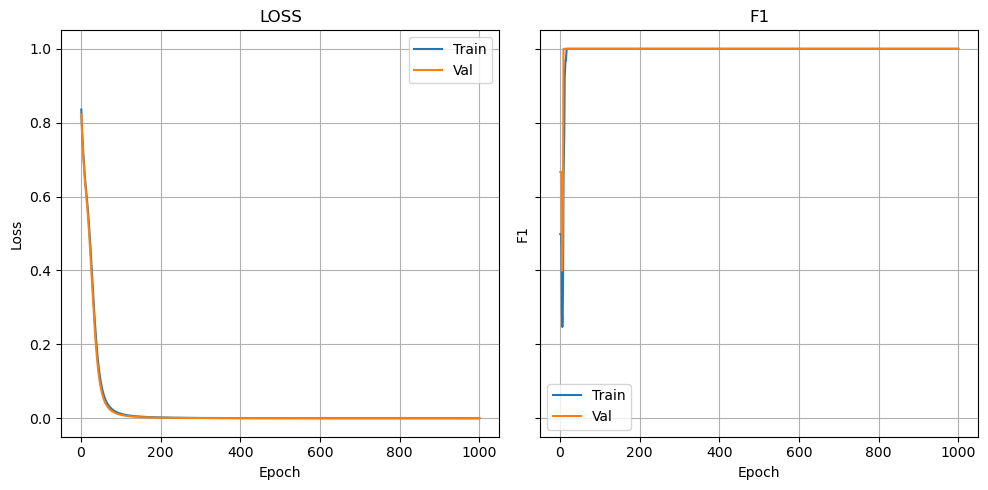

In [19]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

fg, axes=plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
axes[0].plot(range(1, EPOCH+1), LOSS_HISTORY[0][:EPOCH], label='Train')
axes[0].plot(range(1, EPOCH+1), LOSS_HISTORY[1][:EPOCH], label='Val')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("LOSS")

axes[1].plot(range(1, EPOCH+1), SCORE_HISTORY[0][:EPOCH], label='Train')
axes[1].plot(range(1, EPOCH+1), SCORE_HISTORY[1][:EPOCH], label='Val')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("F1")
axes[1].set_title("F1")
plt.tight_layout()
plt.show()

[6] 테스트

In [21]:
# 모델 검증 모드 설정
model.eval()
with torch.no_grad():
    # 검증 데이터셋
    test_featrueTS=torch.FloatTensor(testDS.featureDF.values).to(DEVICE)
    test_targetTS=torch.FloatTensor(testDS.targetDF.values).to(DEVICE)
    
    # 추론/평가
    pre_test=model(test_featrueTS)

    # 손실
    loss_test=crossLoss(pre_test, test_targetTS)
    
    # 성능평가
    # score_val=F1Score(task='binary')(pre_test, val_targetTS)
    score_Test=BinaryF1Score()(pre_test, test_targetTS)
    
print(f'- [TEST] LOSS : {loss_test.item()} SCORE : {score_Test.item()}')

- [TEST] LOSS : 7.074498626025161e-06 SCORE : 1.0
